**Classification Predicitive Modeling** for **Apprentice Chef**

1. Objective: Build machine learning model to predict customers who will subscribe to Halfway There service.


2. Machine Learning Method:
    
    i. Predict the TARGET variable **CROSS_SELL_SUCCESS**. There are a number of variables provided to support the prediction, i.e: Revenue, Total Meals Order, Weekly Meal Plan, etc. Out of 29 columns, 4 are categorical and 25 are numerical.
    
    ii. Feature extraction with Collinearity by finding relationships between multiple predictors at once or called as multi-collinearity. Other techniques was by setting a certain threshold from analyzing the shape of the data.
    
    iii. Data scaling and model tuning to optimize accuracy.


3. Choosing between models:
    
    i. Start with several models that are interpretable and most flexible
    
    ii. Consider using the simplest model that reasonably approximates the best performance

In [455]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf                # statsmodel
from sklearn.model_selection import train_test_split # train, test, and split
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # Optimal neighbors
from sklearn.ensemble import GradientBoostingClassifier # Gradient Bossting for classification
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler       # MinMax scaler
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.model_selection import GridSearchCV     # Hyperparameter tuning
from sklearn.metrics import make_scorer              # model scoring
from sklearn.metrics import roc_curve                # visualize roc curve

# Pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [456]:
# Loading dataset
chef = pd.read_excel('Apprentice_Chef_Dataset.xlsx')

**1. Feature Engineering with Categorical Variables.**

Starting our feature engineering process by encoding categorical variables that are important to our predictive model. 
Categorical variables in this dataset:
  - Name
  - First Name
  - Family Name
  - Email
 
Firstly, since variables "Name" and "First Name" are considered unnecessary for analysis, we have to take out those variables from dataframe "Chef".

In [457]:
# First, dropping out categorical variables that are not useful
chef = chef.drop(labels = ['NAME', 'FIRST_NAME'],
                 axis = 1)

   - **Email** variable is considerably useful for the analysis. Using **hot encoding** function, we will convert the all of the email data as **email domain group** into binary value

In [458]:
# Creating a placeholder list
placeholder_lst = []

# Looping over each email address
for index, col in chef.iterrows():
    split_email = chef.loc[index, 'EMAIL'].split(sep = '@')
    placeholder_lst.append(split_email)
    
# Converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)

# Renaming column to concatenate
email_df.columns = ['id' , 'email_domain']

# Concatenating personal_email_domain with Chef dataframe
chef = pd.concat([chef, email_df['email_domain']], axis = 1)

In [459]:
# Setting condition for professional email domain
professional_email_domains = ['@mmm.com',
                              '@amex.com',
                              '@apple.com',
                              '@boeing.com',
                              '@caterpillar.com',
                              '@chevron.com',
                              '@cisco.com',
                              '@cocacola.com',
                              '@disney.com',
                              '@dupont.com',
                              '@exxon.com',
                              '@ge.org',
                              '@goldmansacs.com',
                              '@homedepot.com',
                              '@ibm.com',
                              '@intel.com',
                              '@jnj.com',
                              '@jpmorgan.com',
                              '@mcdonalds.com',
                              '@merck.com',
                              '@microsoft.com',
                              '@nike.com',
                              '@pfizer.com',
                              '@pg.com',
                              '@travelers.com',
                              '@unitedtech.com',
                              '@unitedhealth.com',
                              '@verizon.com',
                              '@visa.com',
                              '@walmart.com']
 
# Setting condition for personal email domain    
personal_email_domains  = ['@gmail.com',
                           '@yahoo.com',
                           '@protonmail.com']

# Setting condition for junk email domain
junk_email_domains  = ['@me.com',
                       '@aol.com',
                       '@hotmail.com',
                       '@live.com',
                       '@msn.com',
                       '@passport.com']

# Creating placeholder
domain_group_lst=[]

# Looping email domain to conditions
for domain in chef['email_domain']:
    if '@' + domain in professional_email_domains:
        domain_group_lst.append('professional_email')
        
    elif '@' + domain in personal_email_domains:
        domain_group_lst.append('personal_email')
    
    elif '@' + domain in junk_email_domains:
        domain_group_lst.append('junk_email')
    
    else:
        print('Unknown')

chef['domain_group'] = pd.Series(domain_group_lst)

- By visualizing the weight of 3 email domain groups to show us an estimate of mean value of each attributes.

- We can see that professional and personal domain email group are dominating. So we can eliminate junk email as we want to avoid having Nan or infinity values by having too many dummy variables.

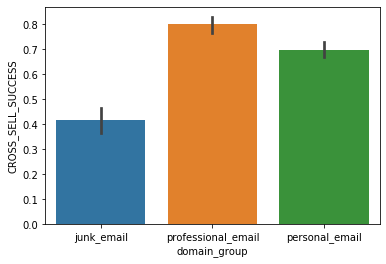

In [460]:
# Plotting email domain group
sns.barplot(x = 'domain_group', 
            y = 'CROSS_SELL_SUCCESS', 
            data = chef)

- Checking number of each value appears in **Family Name** using .value_counts() function, we can see that there are one family name that is significantly used by customers, **Frey**. We can encode this variable for further analysis.

In [461]:
chef['FAMILY_NAME'].value_counts()

Frey                  79
Stark                 32
Lannister             29
Tyrell                28
Targaryen             24
                      ..
Joseran                1
Nute                   1
Wylla                  1
Urreg                  1
Pate of Maidenpool     1
Name: FAMILY_NAME, Length: 1070, dtype: int64

In [462]:
# More than 70 customers are using the same family name "Frey"
# Extracting new feature to see the correlation within this attribute to target variable 

# First we impute missing values with "Unknown"
chef['FAMILY_NAME'] = chef['FAMILY_NAME'].fillna('Unknown')

# Creating placeholder
chef['NEW_FAMILY_NAME_FREY'] = 0

# Replacing values based on a condition
for index, val in chef.iterrows():
    # New features for customers under the same family name "Frey"
    if chef.loc[index, 'FAMILY_NAME'] == 'Frey':
        chef.loc[index, 'NEW_FAMILY_NAME_FREY'] = 1


In [463]:
# One hot encoding variables email domain group
one_hot_domain_group = pd.get_dummies(chef['domain_group'])

# Joining new variables to dataframe
chef = chef.join([one_hot_domain_group])

# Taking out original and other unnecessary features
chef = chef.drop(labels = ['EMAIL', 'FAMILY_NAME', 'domain_group', 'email_domain'], axis =1)

In [464]:
# Checking all feature with new encoded ones
chef.columns

Index(['REVENUE', 'CROSS_SELL_SUCCESS', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'MOBILE_LOGINS', 'PC_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED', 'NEW_FAMILY_NAME_FREY', 'junk_email', 'personal_email', 'professional_email'], dtype='object')

**2. Feature Engineering with Numerical Variables.**

For feature extraction, we start the feature engineering by analyzing the correlation between explanatory variables to target variable. Target variable is **Cross Sell Success**

In [465]:
# Calculating correlation with target variable
chef_corr = chef.corr().round(2)
chef_corr.loc['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

CROSS_SELL_SUCCESS              1.00
FOLLOWED_RECOMMENDATIONS_PCT    0.46
professional_email              0.19
CANCELLATIONS_BEFORE_NOON       0.16
MOBILE_NUMBER                   0.10
TASTES_AND_PREFERENCES          0.08
REFRIGERATED_LOCKER             0.07
personal_email                  0.04
CONTACTS_W_CUSTOMER_SERVICE     0.04
MASTER_CLASSES_ATTENDED         0.04
PACKAGE_LOCKER                  0.04
MOBILE_LOGINS                   0.04
MEDIAN_MEAL_RATING              0.03
AVG_PREP_VID_TIME               0.03
EARLY_DELIVERIES                0.02
LARGEST_ORDER_SIZE              0.02
LATE_DELIVERIES                 0.01
TOTAL_PHOTOS_VIEWED             0.01
AVG_TIME_PER_SITE_VISIT         0.01
TOTAL_MEALS_ORDERED             0.01
PRODUCT_CATEGORIES_VIEWED       0.00
UNIQUE_MEALS_PURCH              0.00
REVENUE                         0.00
WEEKLY_PLAN                    -0.01
NEW_FAMILY_NAME_FREY           -0.01
AVG_CLICKS_PER_VISIT           -0.04
PC_LOGINS                      -0.05
C

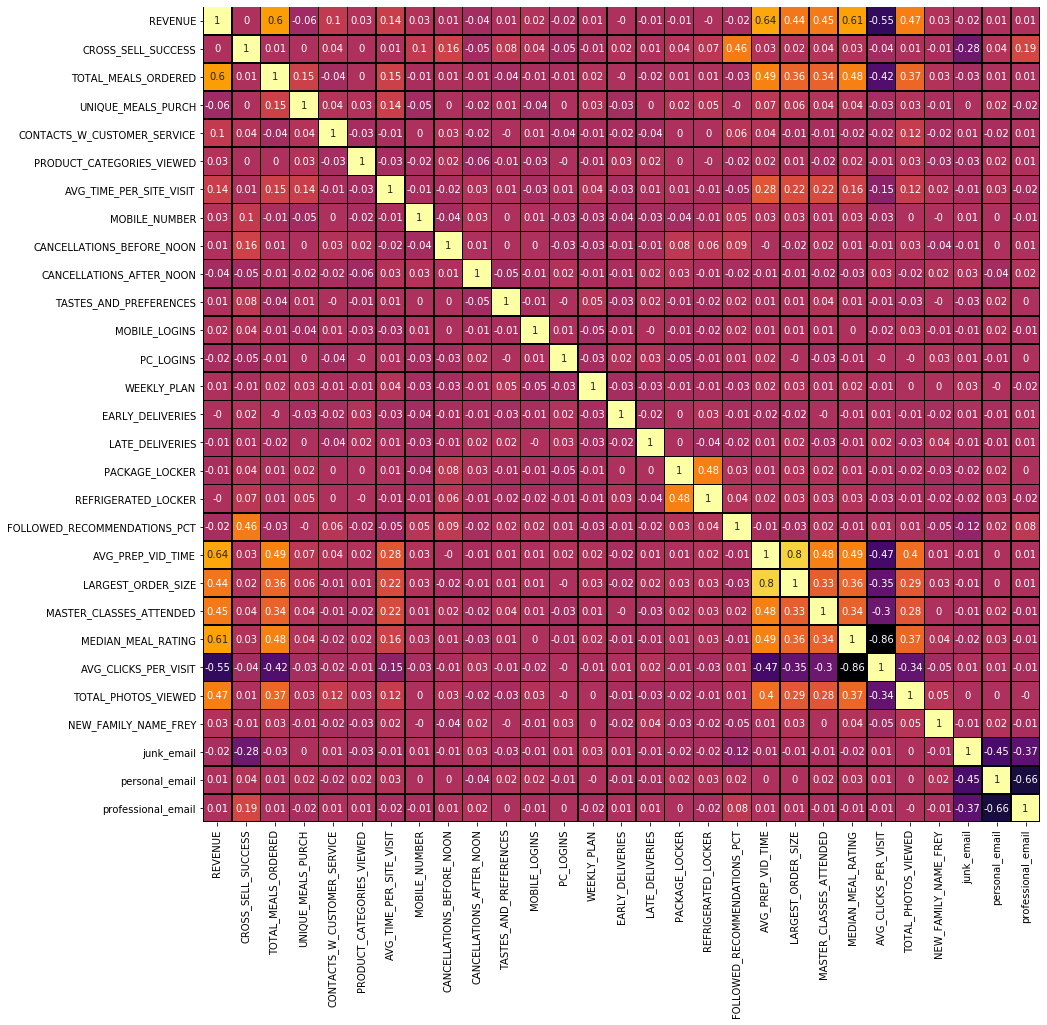

In [466]:
# Visualizing correlation using heatmap
fig, ax = plt.subplots(figsize = (15, 15))

sns.heatmap(data = chef_corr,
            cmap = 'inferno',
            square = False,
            annot = True,
            linecolor = 'black',
            linewidths = 0.5,
            cbar = False)

# Reconfiguring the plot
bottom, top = plt.ylim() # Discovering the values for bottom and top
bottom += 0.5            # Adding 0.5 to the bottom
top -= 0.5               # Subtracting 0.5 from the top
plt.ylim(bottom, top)    # Updating the ylim(bottom, top) values

plt.show()

**Feature extractions:**
- **Correlation matrix.** We can see that some variables are significantly correlated one to another. We are now combining two variables to create a new feature that will be useful to support our further predictive model.
- **Treshold based features.** Other technique for feature engineering is by setting a new treshold from current dataset and extract new features. To be able to do that, we need to see the shape of the data distribution. 

In [467]:
# Building new features based on significance level of correlation


# New feature for "Median Meals Rating & Avg Clicks Per Visit" with correlation: -0.86
feature_2 = chef['MEDIAN_MEAL_RATING'] * chef['AVG_CLICKS_PER_VISIT']
feature_2_df = pd.DataFrame(feature_2)
feature_2_df.columns = ['NEW_RATING_AND_CLICKS_PER_VISIT']
chef = pd.concat([chef, feature_2_df['NEW_RATING_AND_CLICKS_PER_VISIT']], axis = 1)


# New feature for "Contacts with Customer Service per Total Meals Ordered" with correlation: -0.04
feature_3 = chef['CONTACTS_W_CUSTOMER_SERVICE'] / chef['TOTAL_MEALS_ORDERED']
feature_3_df = pd.DataFrame(feature_3)
feature_3_df.columns = ['NEW_PERCENTAGE_COMPLAINT_TO_ORDER']
chef = pd.concat([chef, feature_3_df['NEW_PERCENTAGE_COMPLAINT_TO_ORDER']], axis = 1)


# New feature for "Cross Sell Success & Followed Recommendation Picture" with correlation : 0.46
feature_4 = chef['CROSS_SELL_SUCCESS'] * chef['FOLLOWED_RECOMMENDATIONS_PCT']
feature_4_df = pd.DataFrame(feature_4)
feature_4_df.columns = ['FOLLOWED_RECO_PICTURE_SUCCEED']
chef = pd.concat([chef, feature_4_df['FOLLOWED_RECO_PICTURE_SUCCEED']], axis = 1)



# New feature for "Avg Photos Viewed per Total Meals Ordered" with correlation 0.37
feature_6 = chef['TOTAL_PHOTOS_VIEWED'] / chef['TOTAL_MEALS_ORDERED']
feature_6_df = pd.DataFrame(feature_6)
feature_6_df.columns = ['NEW_PHOTOS_VIEWED_PER_MEALS_ORDERED']
chef = pd.concat([chef, feature_6_df['NEW_PHOTOS_VIEWED_PER_MEALS_ORDERED']], axis = 1)


# New feature for "Revenue Per Clicks Visit" with correlation: -0.55
feature_7 = chef['REVENUE'] * chef['AVG_CLICKS_PER_VISIT']
feature_7_df = pd.DataFrame(feature_7)
feature_7_df.columns = ['NEW_REVENUE_PER_CLICKS_VISIT']
chef = pd.concat([chef, feature_7_df['NEW_REVENUE_PER_CLICKS_VISIT']], axis = 1)


# New feature for "Meals Rating & Photos Viewed" with correlation: 0.37
feature_8 = chef['MEDIAN_MEAL_RATING'] * chef['TOTAL_PHOTOS_VIEWED']
feature_8_df = pd.DataFrame(feature_8)
feature_8_df.columns = ['NEW_RATING_AND_PHOTOS_VIEWED']
chef = pd.concat([chef, feature_8_df['NEW_RATING_AND_PHOTOS_VIEWED']], axis = 1)


# New feature for "Meals Ordered & Clicks Per Visit" with correlation: -0.47
feature_9 = chef['TOTAL_MEALS_ORDERED'] * chef['AVG_CLICKS_PER_VISIT']
feature_9_df = pd.DataFrame(feature_9)
feature_9_df.columns = ['NEW_MEALS_ORDERED_CLICKS_PER_VISIT']
chef = pd.concat([chef, feature_9_df['NEW_MEALS_ORDERED_CLICKS_PER_VISIT']], axis = 1)


# New feature for "Refrigerated and Package Locker" with correlation: -0.55
feature_10 = chef['REFRIGERATED_LOCKER'] * chef['PACKAGE_LOCKER']
feature_10_df = pd.DataFrame(feature_10)
feature_10_df.columns = ['NEW_LOCKERS_BOTH']
chef = pd.concat([chef, feature_10_df['NEW_LOCKERS_BOTH']], axis = 1)


Text(0.5, 0, 'Avg Clicks Per Visit')

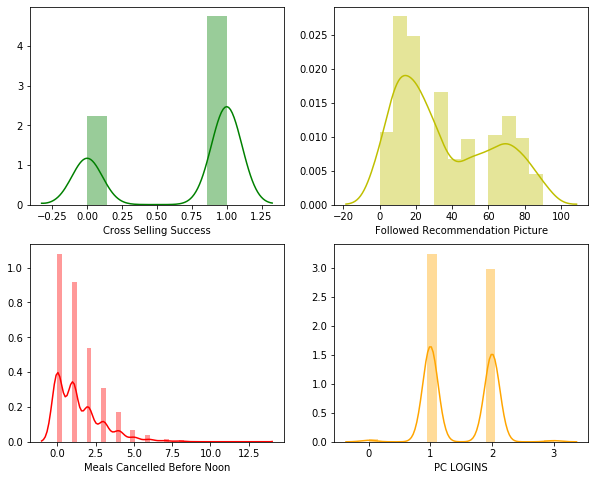

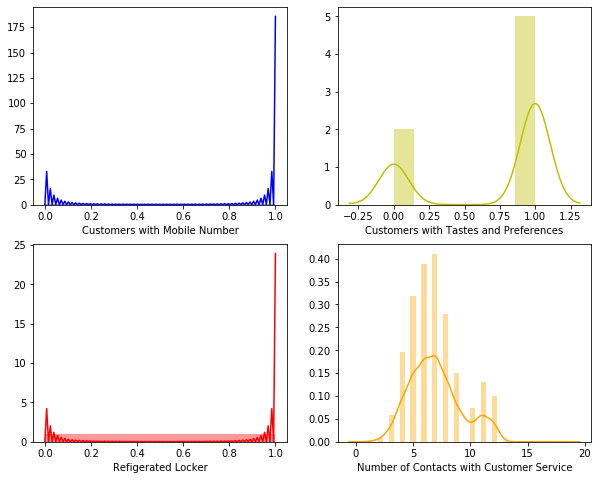

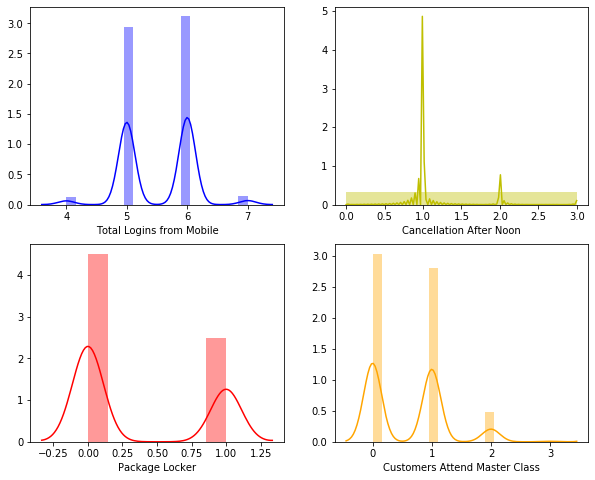

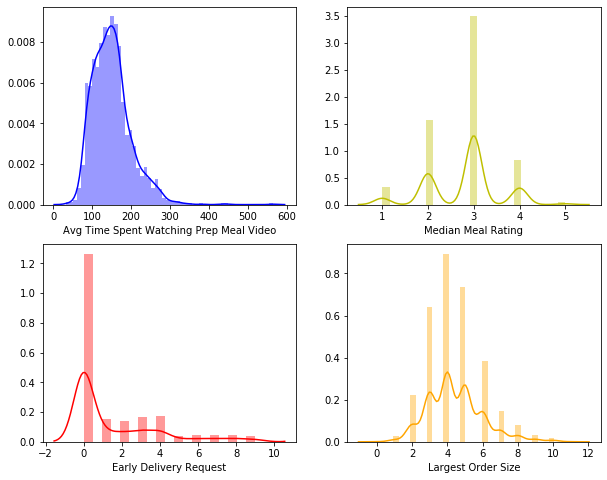

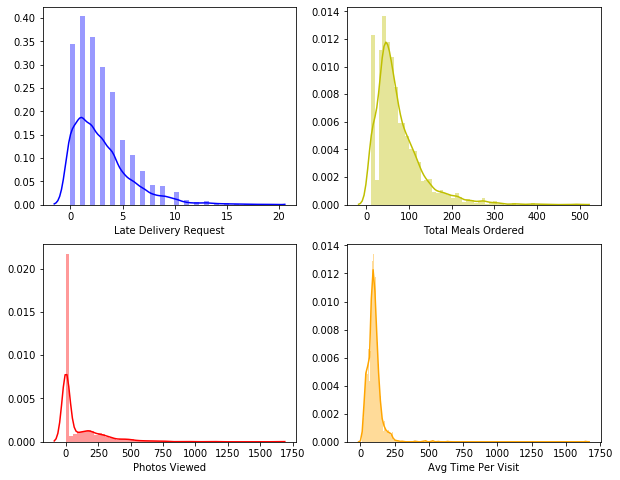

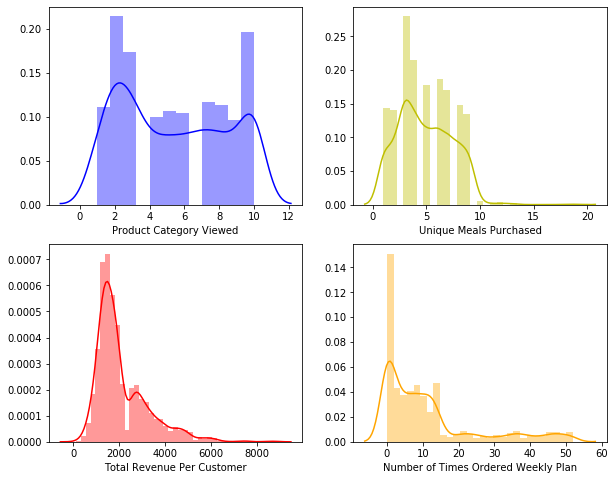

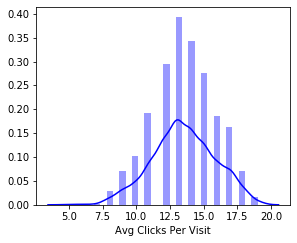

In [468]:
# Feature engineering by analyzing shape of the data for each variables
fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef['CROSS_SELL_SUCCESS'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('Cross Selling Success')

########################

plt.subplot(2, 2, 2)
sns.distplot(chef['FOLLOWED_RECOMMENDATIONS_PCT'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Followed Recommendation Picture')

########################

plt.subplot(2, 2, 3)
sns.distplot(chef['CANCELLATIONS_BEFORE_NOON'],
             bins  = 'fd',
             color = 'red')
plt.xlabel('Meals Cancelled Before Noon')

########################

plt.subplot(2, 2, 4)
sns.distplot(chef['PC_LOGINS'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('PC LOGINS')

################################################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef['MOBILE_NUMBER'],
             bins  = 'fd',
             color = 'blue')
plt.xlabel('Customers with Mobile Number')

########################

plt.subplot(2, 2, 2)
sns.distplot(chef['TASTES_AND_PREFERENCES'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Customers with Tastes and Preferences')

########################

plt.subplot(2, 2, 3)
sns.distplot(chef['REFRIGERATED_LOCKER'],
             bins  = 'fd',
             color = 'red')
plt.xlabel('Refigerated Locker')

########################

plt.subplot(2, 2, 4)
sns.distplot(chef['CONTACTS_W_CUSTOMER_SERVICE'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('Number of Contacts with Customer Service')

################################################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef['MOBILE_LOGINS'],
             bins  = 'fd',
             color = 'blue')
plt.xlabel('Total Logins from Mobile')

########################

plt.subplot(2, 2, 2)
sns.distplot(chef['CANCELLATIONS_AFTER_NOON'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Cancellation After Noon')

########################

plt.subplot(2, 2, 3)
sns.distplot(chef['PACKAGE_LOCKER'],
             bins  = 'fd',
             color = 'red')
plt.xlabel('Package Locker')

########################

plt.subplot(2, 2, 4)
sns.distplot(chef['MASTER_CLASSES_ATTENDED'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('Customers Attend Master Class')

################################################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef['AVG_PREP_VID_TIME'],
             bins  = 'fd',
             color = 'blue')
plt.xlabel('Avg Time Spent Watching Prep Meal Video')

########################

plt.subplot(2, 2, 2)
sns.distplot(chef['MEDIAN_MEAL_RATING'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Median Meal Rating')

########################

plt.subplot(2, 2, 3)
sns.distplot(chef['EARLY_DELIVERIES'],
             bins  = 'fd',
             color = 'red')
plt.xlabel('Early Delivery Request')

########################

plt.subplot(2, 2, 4)
sns.distplot(chef['LARGEST_ORDER_SIZE'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('Largest Order Size')

################################################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef['LATE_DELIVERIES'],
             bins  = 'fd',
             color = 'blue')
plt.xlabel('Late Delivery Request')

########################

plt.subplot(2, 2, 2)
sns.distplot(chef['TOTAL_MEALS_ORDERED'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Total Meals Ordered')

########################

plt.subplot(2, 2, 3)
sns.distplot(chef['TOTAL_PHOTOS_VIEWED'],
             bins  = 'fd',
             color = 'red')
plt.xlabel('Photos Viewed')

########################

plt.subplot(2, 2, 4)
sns.distplot(chef['AVG_TIME_PER_SITE_VISIT'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('Avg Time Per Visit')

################################################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef['PRODUCT_CATEGORIES_VIEWED'],
             bins  = 'fd',
             color = 'blue')
plt.xlabel('Product Category Viewed')

########################

plt.subplot(2, 2, 2)
sns.distplot(chef['UNIQUE_MEALS_PURCH'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Unique Meals Purchased')

########################

plt.subplot(2, 2, 3)
sns.distplot(chef['REVENUE'],
             bins  = 'fd',
             color = 'red')
plt.xlabel('Total Revenue Per Customer')

########################

plt.subplot(2, 2, 4)
sns.distplot(chef['WEEKLY_PLAN'],
             bins  = 'fd',
             color = 'orange')
plt.xlabel('Number of Times Ordered Weekly Plan')

################################################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef['AVG_CLICKS_PER_VISIT'],
             bins  = 'fd',
             color = 'blue')
plt.xlabel('Avg Clicks Per Visit')

########################


In [469]:
# Customers who follow recommendation picture
# Preparing placeholder
chef['NEW_FOLLOWED_RECOMMENDATIONS_PCT_LO'] = 0

# Replacing values based on a condition
for index, val in chef.iterrows():
    # New features for customers who followed less and equal to 20 pictures
    if chef.loc[index, 'FOLLOWED_RECOMMENDATIONS_PCT'] <= 20:
        chef.loc[index, 'NEW_FOLLOWED_RECOMMENDATIONS_PCT_LO'] = 1 

In [470]:
# Customers who alwayws order weekly plan every week
# Preparing placeholder
chef['NEW_WEEKLY_PLAN_ALWAYS'] = 0

# Replacing values based on a condition
for index, val in chef.iterrows():
    # New features 
    if chef.loc[index, 'WEEKLY_PLAN'] == 52:
        chef.loc[index, 'NEW_WEEKLY_PLAN_ALWAYS'] = 1

In [471]:
# Number of times customer views meals category
# Preparing placeholder
chef['NEW_PRODUCT_CATEGORIES_VIEWED_HI'] = 0
chef['NEW_PRODUCT_CATEGORIES_VIEWED_LO'] = 0

# Replacing values based on 2 significant tresholds
for index, val in chef.iterrows():
    # New features for views equal to 10 times
    if chef.loc[index, 'PRODUCT_CATEGORIES_VIEWED'] == 10:
        chef.loc[index, 'NEW_PRODUCT_CATEGORIES_VIEWED_HI'] = 1
    # New features for views equal to 2 times
    elif chef.loc[index, 'PRODUCT_CATEGORIES_VIEWED'] == 2:
        chef.loc[index, 'NEW_PRODUCT_CATEGORIES_VIEWED_LO'] = 1

In [472]:
# Customers who made higher total order
# Preparing placeholder
chef['NEW_TOTAL_MEALS_ORDERED_HI'] = 0

# Replacing values based on unique meals purchased above 10 meals
for index, val in chef.iterrows():
    # New features for order above 200 times
    if chef.loc[index, 'TOTAL_MEALS_ORDERED'] >= 200:
        chef.loc[index, 'NEW_TOTAL_MEALS_ORDERED_HI'] = 1

In [473]:
# Customers who are likely to try more meals
# Preparing placeholder
chef['NEW_UNIQUE_MEALS_PURCH_HI'] = 0

# Replacing values based on unique meals purchased above 10 meals
for index, val in chef.iterrows():
    # New features for largest order made at once
    if chef.loc[index, 'UNIQUE_MEALS_PURCH'] >= 10:
        chef.loc[index, 'NEW_UNIQUE_MEALS_PURCH_HI'] = 1

In [474]:
# Customers with the largest number of meals ordered in one order
# Preparing placeholder
chef['NEW_LARGEST_ORDER_SIZE_HI'] = 0

# Replacing values based on a condition
for index, val in chef.iterrows():
    # New features for largest order made at once
    if chef.loc[index, 'LARGEST_ORDER_SIZE'] == 4: # Most people purchased 4 meals in one order
        chef.loc[index, 'NEW_LARGEST_ORDER_SIZE_HI'] = 1

In [475]:
# Customers who never cancelled order before noon
# Preparing placeholder
chef['NEW_CANCELLATIONS_BEFORE_NOON_5'] = 0

# Replacing values based on a condition
for index, val in chef.iterrows():
    if chef.loc[index, 'CANCELLATIONS_BEFORE_NOON'] >= 5:
        chef.loc[index, 'NEW_CANCELLATIONS_BEFORE_NOON_5'] = 1

In [476]:
# Customers who never cancelled order after noon
# Preparing placeholder
chef['NEW_CANCELLATIONS_AFTER_NOON_2'] = 0

# Replacing values based on a condition
for index, val in chef.iterrows():
    if chef.loc[index, 'CANCELLATIONS_AFTER_NOON'] >= 2:
        chef.loc[index, 'NEW_CANCELLATIONS_AFTER_NOON_2'] = 1

- Saving all new features into new dataset before moving forward to next step

In [477]:
# Saving results with all new features
chef.to_excel('Apprentice_Chef_Dataset_features_rich.xlsx', 
              index = False)

In [478]:
# Checking descriptive statistics all new features
chef.describe().round(3)

,REVENUE,CROSS_SELL_SUCCESS,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,MOBILE_LOGINS,PC_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,FOLLOWED_RECOMMENDATIONS_PCT,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,NEW_FAMILY_NAME_FREY,junk_email,personal_email,professional_email,NEW_RATING_AND_CLICKS_PER_VISIT,NEW_PERCENTAGE_COMPLAINT_TO_ORDER,FOLLOWED_RECO_PICTURE_SUCCEED,NEW_PHOTOS_VIEWED_PER_MEALS_ORDERED,NEW_REVENUE_PER_CLICKS_VISIT,NEW_RATING_AND_PHOTOS_VIEWED,NEW_MEALS_ORDERED_CLICKS_PER_VISIT,NEW_LOCKERS_BOTH,NEW_FOLLOWED_RECOMMENDATIONS_PCT_LO,NEW_WEEKLY_PLAN_ALWAYS,NEW_PRODUCT_CATEGORIES_VIEWED_HI,NEW_PRODUCT_CATEGORIES_VIEWED_LO,NEW_TOTAL_MEALS_ORDERED_HI,NEW_UNIQUE_MEALS_PURCH_HI,NEW_LARGEST_ORDER_SIZE_HI,NEW_CANCELLATIONS_BEFORE_NOON_5,NEW_CANCELLATIONS_AFTER_NOON_2
count,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.0,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000,1946.000
mean,2107.293,0.679,74.634,4.905,6.984,5.384,99.605,0.878,1.405,0.166,0.714,5.516,1.476,11.330,1.486,2.971,0.355,0.113,35.411,150.557,4.437,0.604,2.795,13.508,106.434,0.041,0.2,0.442,0.358,36.242,0.182,29.800,1.564,26995.265,348.005,953.563,0.113,0.473,0.009,0.147,0.161,0.040,0.010,0.281,0.045,0.021
std,1138.291,0.467,55.310,2.502,2.281,3.044,62.342,0.328,1.550,0.432,0.452,0.581,0.528,13.573,2.319,2.745,0.479,0.317,26.578,49.447,1.551,0.642,0.757,2.334,181.014,0.197,0.4,0.497,0.479,6.380,0.235,30.794,3.480,12034.907,633.547,635.270,0.317,0.499,0.093,0.355,0.367,0.196,0.098,0.450,0.207,0.144
min,131.000,0.000,11.000,1.000,1.000,1.000,10.330,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,33.400,0.000,0.000,1.000,5.000,0.000,0.000,0.0,0.000,0.000,15.000,0.015,0.000,0.000,1572.000,0.000,132.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1350.000,0.000,39.000,3.000,5.000,3.000,72.000,1.000,0.000,0.000,0.000,5.000,1.000,1.000,0.000,1.000,0.000,0.000,10.000,114.400,3.000,0.000,2.000,12.000,0.000,0.000,0.0,0.000,0.000,33.000,0.065,0.000,0.000,19100.250,0.000,546.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1740.000,1.000,60.000,5.000,7.000,5.000,94.160,1.000,1.000,0.000,1.000,6.000,1.000,7.000,0.000,2.000,0.000,0.000,30.000,145.600,4.000,1.000,3.000,13.000,0.000,0.000,0.0,0.000,0.000,36.000,0.102,20.000,0.000,23525.000,0.000,780.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,2670.000,1.000,95.000,7.000,8.000,8.000,117.288,1.000,2.000,0.000,1.000,6.000,2.000,13.000,3.000,4.000,1.000,0.000,60.000,173.775,5.000,1.000,3.000,15.000,174.000,0.000,0.0,1.000,1.000,40.000,0.152,60.000,2.164,32930.625,517.500,1215.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
max,8793.750,1.000,493.000,19.000,18.000,10.000,1645.600,1.000,13.000,3.000,1.000,7.000,3.000,52.000,9.000,19.000,1.000,1.000,90.000,564.200,11.000,3.000,5.000,19.000,1600.000,1.000,1.0,1.000,1.000,48.000,1.000,90.000,55.071,116865.000,4800.000,5423.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [479]:
# Calculating correlation with target variable
chef_corr = chef.corr().round(2)
chef_corr.loc['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

CROSS_SELL_SUCCESS                     1.00
FOLLOWED_RECO_PICTURE_SUCCEED          0.67
FOLLOWED_RECOMMENDATIONS_PCT           0.46
professional_email                     0.19
CANCELLATIONS_BEFORE_NOON              0.16
MOBILE_NUMBER                          0.10
TASTES_AND_PREFERENCES                 0.08
REFRIGERATED_LOCKER                    0.07
NEW_LOCKERS_BOTH                       0.07
NEW_CANCELLATIONS_BEFORE_NOON_5        0.06
MASTER_CLASSES_ATTENDED                0.04
MOBILE_LOGINS                          0.04
personal_email                         0.04
PACKAGE_LOCKER                         0.04
CONTACTS_W_CUSTOMER_SERVICE            0.04
NEW_PRODUCT_CATEGORIES_VIEWED_HI       0.03
AVG_PREP_VID_TIME                      0.03
MEDIAN_MEAL_RATING                     0.03
NEW_PHOTOS_VIEWED_PER_MEALS_ORDERED    0.02
NEW_RATING_AND_CLICKS_PER_VISIT        0.02
EARLY_DELIVERIES                       0.02
LARGEST_ORDER_SIZE                     0.02
LATE_DELIVERIES                 

- Checking if there is missing values or not.

In [480]:
chef.isnull().values.any()

False

**3. Setting up classification model:**
- Declaring explanatory variables as **chef_full** and **chef_target** as target variable
- Preparing **training and testing** sets with stratification as this is classification model

In [481]:
# Loading new dataset
chef = pd.read_excel('Apprentice_Chef_Dataset_features_rich.xlsx')

# Assigning explanatory variable by dropping target and categorical variables
chef_full = chef.drop(labels = 'CROSS_SELL_SUCCESS', axis = 1)

# Assigning target variable
chef_target = chef.loc[ : , 'CROSS_SELL_SUCCESS']

In [482]:
# Train-test-split with stratification
X_train, X_test, y_train, y_test = train_test_split(chef_full,
                                                    chef_target,
                                                    test_size = 0.25,
                                                    random_state = 222,
                                                    stratify = chef_target)

# Merging training dataset for statsmodels
chef_train = pd.concat([X_train, y_train], axis = 1)

In [483]:
# Looping explanatory variables before building logistic regression
for val in chef_full:
    print(f"{val} +")

REVENUE +
TOTAL_MEALS_ORDERED +
UNIQUE_MEALS_PURCH +
CONTACTS_W_CUSTOMER_SERVICE +
PRODUCT_CATEGORIES_VIEWED +
AVG_TIME_PER_SITE_VISIT +
MOBILE_NUMBER +
CANCELLATIONS_BEFORE_NOON +
CANCELLATIONS_AFTER_NOON +
TASTES_AND_PREFERENCES +
MOBILE_LOGINS +
PC_LOGINS +
WEEKLY_PLAN +
EARLY_DELIVERIES +
LATE_DELIVERIES +
PACKAGE_LOCKER +
REFRIGERATED_LOCKER +
FOLLOWED_RECOMMENDATIONS_PCT +
AVG_PREP_VID_TIME +
LARGEST_ORDER_SIZE +
MASTER_CLASSES_ATTENDED +
MEDIAN_MEAL_RATING +
AVG_CLICKS_PER_VISIT +
TOTAL_PHOTOS_VIEWED +
NEW_FAMILY_NAME_FREY +
junk_email +
personal_email +
professional_email +
NEW_RATING_AND_CLICKS_PER_VISIT +
NEW_PERCENTAGE_COMPLAINT_TO_ORDER +
FOLLOWED_RECO_PICTURE_SUCCEED +
NEW_PHOTOS_VIEWED_PER_MEALS_ORDERED +
NEW_REVENUE_PER_CLICKS_VISIT +
NEW_RATING_AND_PHOTOS_VIEWED +
NEW_MEALS_ORDERED_CLICKS_PER_VISIT +
NEW_LOCKERS_BOTH +
NEW_FOLLOWED_RECOMMENDATIONS_PCT_LO +
NEW_WEEKLY_PLAN_ALWAYS +
NEW_PRODUCT_CATEGORIES_VIEWED_HI +
NEW_PRODUCT_CATEGORIES_VIEWED_LO +
NEW_TOTAL_MEALS_ORDE

**3.a.** Buidling **OLS Model** using full variables

In [484]:
# Computing full model with all explanatory variables
log_full = smf.logit(formula   = """CROSS_SELL_SUCCESS ~ 
                                    REVENUE +
                                    TOTAL_MEALS_ORDERED +
                                    UNIQUE_MEALS_PURCH +
                                    CONTACTS_W_CUSTOMER_SERVICE +
                                    PRODUCT_CATEGORIES_VIEWED +
                                    AVG_TIME_PER_SITE_VISIT +
                                    MOBILE_NUMBER +
                                    CANCELLATIONS_BEFORE_NOON +
                                    CANCELLATIONS_AFTER_NOON +
                                    TASTES_AND_PREFERENCES +
                                    MOBILE_LOGINS +
                                    PC_LOGINS +
                                    WEEKLY_PLAN +
                                    EARLY_DELIVERIES +
                                    LATE_DELIVERIES +
                                    PACKAGE_LOCKER +
                                    REFRIGERATED_LOCKER +
                                    FOLLOWED_RECOMMENDATIONS_PCT +
                                    AVG_PREP_VID_TIME +
                                    LARGEST_ORDER_SIZE +
                                    MASTER_CLASSES_ATTENDED +
                                    MEDIAN_MEAL_RATING +
                                    AVG_CLICKS_PER_VISIT +
                                    TOTAL_PHOTOS_VIEWED +
                                    NEW_FAMILY_NAME_FREY +
                                    junk_email +
                                    personal_email +
                                    professional_email +
                                    NEW_RATING_AND_CLICKS_PER_VISIT +
                                    NEW_PERCENTAGE_COMPLAINT_TO_ORDER +
                                    FOLLOWED_RECO_PICTURE_SUCCEED +
                                    NEW_PHOTOS_VIEWED_PER_MEALS_ORDERED +
                                    NEW_REVENUE_PER_CLICKS_VISIT +
                                    NEW_RATING_AND_PHOTOS_VIEWED +
                                    NEW_MEALS_ORDERED_CLICKS_PER_VISIT +
                                    NEW_LOCKERS_BOTH +
                                    NEW_FOLLOWED_RECOMMENDATIONS_PCT_LO +
                                    NEW_WEEKLY_PLAN_ALWAYS +
                                    NEW_PRODUCT_CATEGORIES_VIEWED_HI +
                                    NEW_PRODUCT_CATEGORIES_VIEWED_LO +
                                    NEW_TOTAL_MEALS_ORDERED_HI +
                                    NEW_UNIQUE_MEALS_PURCH_HI +
                                    NEW_LARGEST_ORDER_SIZE_HI +
                                    NEW_CANCELLATIONS_BEFORE_NOON_5 +
                                    NEW_CANCELLATIONS_AFTER_NOON_2""",
                                    data = chef_train) # stratification set

# Fitting the model object
results_full = log_full.fit()

# Checking the results SUMMARY
results_full.summary()

         Current function value: 0.019377
         Iterations: 35


/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1415
Method:                           MLE   Df Model:                           43
Date:                Fri, 07 Feb 2020   Pseudo R-squ.:                  0.9691
Time:                        09:56:13   Log-Likelihood:                -28.271
converged:                      False   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            -106.6509   2.72e+07  -3.93e-06      1.000   -5.33e+07    5.33e+07
REVENUE                                 0.0007      0.001      0.688      0.492      -0.001       0.003
TOTAL_MEALS_ORDERED                    -0.3548      0.138     -2.574      0.010      -0.625      -0.085
UNIQUE_MEALS_PURCH                     -0.0763      0.215     -0.355      0.723      -0.498       0.346
CONTACTS_W_CUSTOMER_SERVICE             0.1692      0.545      0.310      0.756      -0.900       1.238
PRODUCT_CATEGORIES_VIEWED               0.5059      0.355      1.425      0.154      -0.190       1.202
AVG_TIME_PER_SITE_VISIT                 0.0540      0.019      2.831      0.005       0.017       0.091
MOBILE_NUMBER                           4.4256      1.659      2.668      0.008       1.174       7.677
CANCELLATIONS_BEFORE_NOON               0.7789      0.485      1.605      0.109      -0.173       1.730
CANCELLATIONS_AFTER_NOON               -1.6383      1.696     -0.966      0.334      -4.962       1.686
TASTES_AND_PREFERENCES                 -1.3077      1.476     -0.886      0.376      -4.200       1.585
MOBILE_LOGINS                           1.3265      0.900      1.474      0.141      -0.438       3.091
PC_LOGINS                              -4.9850      1.806     -2.761      0.006      -8.524      -1.446
WEEKLY_PLAN                             0.1171      0.050      2.319      0.020       0.018       0.216
EARLY_DELIVERIES                       -0.1863      0.272     -0.684      0.494      -0.720       0.348
LATE_DELIVERIES                        -0.1623      0.193     -0.841      0.400      -0.540       0.216
PACKAGE_LOCKER                         -0.8002      1.081     -0.741      0.459      -2.918       1.318
REFRIGERATED_LOCKER                    -2.4439   8.53e+14  -2.87e-15      1.000   -1.67e+15    1.67e+15
FOLLOWED_RECOMMENDATIONS_PCT           -5.6732   4.16e+04     -0.000      1.000   -8.15e+04    8.15e+04
AVG_PREP_VID_TIME                      -0.0050      0.024     -0.212      0.832      -0.052       0.042
LARGEST_ORDER_SIZE                     -0.7027      0.671     -1.047      0.295      -2.018       0.613
MASTER_CLASSES_ATTENDED                 1.9762      1.175      1.682      0.093      -0.327       4.279
MEDIAN_MEAL_RATING                     10.3806      6.997      1.484      0.138      -3.334      24.095
AVG_CLICKS_PER_VISIT                    0.0397      0.964      0.041      0.967      -1.849       1.928
TOTAL_PHOTOS_VIEWED                     0.0747      0.021      3.559      0.000       0.034       0.116
NEW_FAMILY_NAME_FREY                    4.2036      2.408      1.746      0.081      -0.515       8.923
junk_email                            -38.1126        nan        nan        nan         nan         nan
personal_email                        -35.5679        nan        nan        nan         nan         nan
professional_emai

**3.b.** Building **OLS Model** after removing insignificant variables based on p-value and coefficient

In [485]:
# Computing final model with selected variables
log_final = smf.logit(formula  = """CROSS_SELL_SUCCESS ~ 
                                    TOTAL_MEALS_ORDERED +
                                    CONTACTS_W_CUSTOMER_SERVICE +
                                    PRODUCT_CATEGORIES_VIEWED +
                                    MOBILE_NUMBER +
                                    CANCELLATIONS_BEFORE_NOON +
                                    CANCELLATIONS_AFTER_NOON +
                                    PC_LOGINS +
                                    EARLY_DELIVERIES +
                                    LATE_DELIVERIES +
                                    PACKAGE_LOCKER +
                                    LARGEST_ORDER_SIZE +
                                    MASTER_CLASSES_ATTENDED +
                                    MEDIAN_MEAL_RATING +
                                    AVG_CLICKS_PER_VISIT +
                                    TOTAL_PHOTOS_VIEWED +
                                    NEW_FAMILY_NAME_FREY +
                                    personal_email +
                                    professional_email +
                                    NEW_MEALS_ORDERED_CLICKS_PER_VISIT +
                                    NEW_LOCKERS_BOTH +
                                    NEW_FOLLOWED_RECOMMENDATIONS_PCT_LO +
                                    NEW_PRODUCT_CATEGORIES_VIEWED_HI +
                                    NEW_PRODUCT_CATEGORIES_VIEWED_LO +
                                    NEW_TOTAL_MEALS_ORDERED_HI +
                                    NEW_CANCELLATIONS_BEFORE_NOON_5""",
                                    data = chef_train)

# Fitting the model object
results_final = log_final.fit()

# Checking the results SUMMARY
results_final.summary()

Optimization terminated successfully.
         Current function value: 0.482546
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1433
Method:                           MLE   Df Model:                           25
Date:                Fri, 07 Feb 2020   Pseudo R-squ.:                  0.2316
Time:                        09:56:13   Log-Likelihood:                -704.03
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 3.197e-74
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.8937      1.428      1.326      0.185      -0.905       4.692
TOTAL_MEALS_ORDERED                    -0.0061      0.007     -0.864      0.388      -0.020       0.008
CONTACTS_W_CUSTOMER_SERVICE             0.0411      0.031      1.326      0.185      -0.020       0.102
PRODUCT_CATEGORIES_VIEWED              -0.0411      0.032     -1.280      0.201      -0.104       0.022
MOBILE_NUMBER                           0.7188      0.192      3.738      0.000       0.342       1.096
CANCELLATIONS_BEFORE_NOON               0.3218      0.058      5.517      0.000       0.207       0.436
CANCELLATIONS_AFTER_NOON               -0.2920      0.148     -1.973      0.049      -0.582      -0.002
PC_LOGINS                              -0.2354      0.125     -1.884      0.060      -0.480       0.009
EARLY_DELIVERIES                        0.0624      0.030      2.099      0.036       0.004       0.121
LATE_DELIVERIES                         0.0279      0.024      1.141      0.254      -0.020       0.076
PACKAGE_LOCKER                         -0.1494      0.157     -0.954      0.340      -0.456       0.157
LARGEST_ORDER_SIZE                      0.0389      0.049      0.799      0.424      -0.057       0.134
MASTER_CLASSES_ATTENDED                 0.1188      0.115      1.034      0.301      -0.106       0.344
MEDIAN_MEAL_RATING                     -0.2676      0.180     -1.483      0.138      -0.621       0.086
AVG_CLICKS_PER_VISIT                   -0.1404      0.070     -1.998      0.046      -0.278      -0.003
TOTAL_PHOTOS_VIEWED                     0.0003      0.000      0.710      0.478      -0.001       0.001
NEW_FAMILY_NAME_FREY                    0.3646      0.319      1.143      0.253      -0.261       0.990
personal_email                          1.2745      0.170      7.487      0.000       0.941       1.608
professional_email                      1.9305      0.187     10.322      0.000       1.564       2.297
NEW_MEALS_ORDERED_CLICKS_PER_VISIT      0.0007      0.001      1.273      0.203      -0.000       0.002
NEW_LOCKERS_BOTH                        0.5711      0.244      2.341      0.019       0.093       1.049
NEW_FOLLOWED_RECOMMENDATIONS_PCT_LO    -1.8104      0.139    -13.048      0.000      -2.082      -1.538
NEW_PRODUCT_CATEGORIES_VIEWED_HI        0.3098      0.246      1.258      0.208      -0.173       0.792
NEW_PRODUCT_CATEGORIES_VIEWED_LO       -0.3015      0.215     -1.401      0.161      -0.723       0.120
NEW_TOTAL_MEALS_ORDERED_HI             -0.7693      0.481     -1.601      0.109      -1.711       0.173
NEW_CANCELLATIONS_BEFORE_NOON_5        -0.9462      0.451     -2.096      0.036      -1.831      -0.061
=======================================================================================================
"""

In [486]:
# Saving final candidate model into explanatory variables
x_variables_final = ['REVENUE' ,
'TOTAL_MEALS_ORDERED' ,
'CONTACTS_W_CUSTOMER_SERVICE' ,
'PRODUCT_CATEGORIES_VIEWED' ,
'MOBILE_NUMBER' ,
'CANCELLATIONS_BEFORE_NOON' ,
'CANCELLATIONS_AFTER_NOON' ,
'PC_LOGINS' ,
'EARLY_DELIVERIES' ,
'LATE_DELIVERIES' ,
'PACKAGE_LOCKER' ,
'LARGEST_ORDER_SIZE' ,
'AVG_CLICKS_PER_VISIT' ,
'MEDIAN_MEAL_RATING' ,
'TOTAL_PHOTOS_VIEWED' ,
'NEW_FAMILY_NAME_FREY' ,
'personal_email' ,
'professional_email' ,
'NEW_MEALS_ORDERED_CLICKS_PER_VISIT' ,
'NEW_LOCKERS_BOTH' ,
'NEW_FOLLOWED_RECOMMENDATIONS_PCT_LO' ,
'NEW_PRODUCT_CATEGORIES_VIEWED_HI' ,
'NEW_PRODUCT_CATEGORIES_VIEWED_LO',
'NEW_TOTAL_MEALS_ORDERED_HI',
'NEW_CANCELLATIONS_BEFORE_NOON_5']

# Storing X from final selected features
chef_features = chef.loc[ : , x_variables_final]

**3.c.** Building baseline **Logistic Regression** model using full features without **hypertuning**

In [487]:
# Train-test-split with stratification
X_train, X_test, y_train, y_test = train_test_split(chef_full,
                                                    chef_target,
                                                    test_size = 0.25,
                                                    random_state = 222,
                                                    stratify = chef_target)

# Setup the model
logreg_full = LogisticRegression(solver = 'lbfgs',
                                 C = 1,
                                 random_state = 222)
# Fit the model
logreg_full_fit = logreg_full.fit(X_train, y_train)

# Predict the model
logreg_full_pred = logreg_full_fit.predict(X_test)

# ROC curve and Area-Under-Curve (AUC) for Logistic Regression Model
roc_auc_logreg_full = roc_auc_score(y_true = y_test,
                                    y_score = logreg_full_pred)

# Print the result
print('Accuracy score Logistic Reg (training):', logreg_full_fit.score(X_train, y_train).round(3))
print('Accuracy score Logistic Reg (testing):', logreg_full_fit.score(X_test, y_test).round(3))
print("Area under ROC curve Logistic Regression: {:0.2f}".format(roc_auc_logreg_full))


Accuracy score Logistic Reg (training): 0.888
Accuracy score Logistic Reg (testing): 0.846
Area under ROC curve Logistic Regression: 0.85


/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


**3.d.** Building baseline **Logistic Regression** model using only selected features without **hypertuning**

In [488]:
# Train-test-split with stratification
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(chef_features,
                                                                        chef_target,
                                                                        test_size = 0.25,
                                                                        random_state = 222,
                                                                        stratify = chef_target)


logreg_feat = LogisticRegression(solver = 'lbfgs',
                                 C = 1,
                                 random_state = 222)

logreg_feat_fit = logreg_feat.fit(X_train_feat, y_train_feat)

logreg_feat_pred = logreg_feat_fit.predict(X_test_feat)

# ROC curve and Area-Under-Curve (AUC) for Logistic Regression Model
roc_auc_logreg_feat = roc_auc_score(y_true = y_test_feat,
                                    y_score = logreg_feat_pred)

# Print the result
print('Accuracy score Log Reg (training):', logreg_feat_fit.score(X_train_feat, y_train_feat).round(3))
print('Accuracy score Log Reg (testing):', logreg_feat_fit.score(X_test_feat, y_test_feat).round(3))
print("Area under ROC curve Log Reg: {:0.2f}".format(roc_auc_logreg_feat))


Accuracy score Log Reg (training): 0.726
Accuracy score Log Reg (testing): 0.702
Area under ROC curve Log Reg: 0.58


/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


**3.e.** Building **Logistic Regression** model with **Hyperparameter Tuning**

In [489]:
# Checking default parameters
help(GridSearchCV)

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs', error_score='raise-deprecating', return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |     

In [490]:
# Setting hyperparameter space
C_space          = pd.np.arange(0.1, 3.0, 0.1)
warm_start_space = [True, False]


# Setting hyperparameter grid
param_grid = {'C'         : C_space,
              'warm_start': warm_start_space}


# Instantiating Logistic Regression model
lr_full_tuned = LogisticRegression(solver = 'warn',
                              max_iter = 100,
                              random_state = 222)


# Setup GridSearchCV object
lr_full_tuned_cv = GridSearchCV(estimator = lr_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring = make_scorer(roc_auc_score,
                                                 needs_threshold = False))


# Cross-validation with the full dataset
lr_full_tuned_cv.fit(chef_full, chef_target)


# Instantiating a logistic regression model with tuned values
lr_full_tuned = lr_full_tuned_cv.best_estimator_


# Predicting based on the testing set
lr_full_tuned_pred = lr_full_tuned.predict(X_test)

print("Tuned Parameters Logistic Reg :", lr_full_tuned_cv.best_params_)
print("Tuned Accuracy score Logistic Reg (training):", lr_full_tuned.score(X_train, y_train).round(3))
print("Tuned Accuracy score Logistic Reg (testing):", lr_full_tuned.score(X_test, y_test).round(3))
print("Tuned Area Under the ROC curve Logistic Reg:", roc_auc_score(y_true  = y_test,
                                                                    y_score = lr_full_tuned_pred).round(4))

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

Tuned Parameters Logistic Reg : {'C': 0.30000000000000004, 'warm_start': True}
Tuned Accuracy score Logistic Reg (training): 0.978
Tuned Accuracy score Logistic Reg (testing): 0.982
Tuned Area Under the ROC curve Logistic Reg: 0.9712


In [491]:
# Setting hyperparameter space
C_space          = pd.np.arange(0.1, 3.0, 0.1)
warm_start_space = [True, False]


# Setting hyperparameter grid
param_grid = {'C'         : C_space,
              'warm_start': warm_start_space}


# Instantiating Logistic Regression model
lr__feat_tuned = LogisticRegression(solver = 'warn',
                                    max_iter = 100,
                                    random_state = 222)


# Setup GridSearchCV object
lr_feat_tuned_cv = GridSearchCV(estimator = lr_tuned,
                           param_grid = param_grid,
                           cv = 3,
                           scoring = make_scorer(roc_auc_score,
                                                 needs_threshold = False))


# Cross-validation with the full dataset
lr_feat_tuned_cv.fit(chef_features, chef_target)


# Instantiating a logistic regression model with tuned values
lr_feat_tuned = lr_feat_tuned_cv.best_estimator_


# Predicting based on the testing set
lr_feat_tuned_pred = lr_tuned.predict(X_test)

# Print the results
print("Tuned Parameters Logistic Reg :", lr_feat_tuned_cv.best_params_)
print("Tuned Accuracy score Logistic Reg (training):", lr_feat_tuned.score(X_train_feat, y_train_feat).round(3))
print("Tuned Accuracy score Logistic Reg (testing):", lr_feat_tuned.score(X_test_feat, y_test_feat).round(3))
print("Tuned Area Under the ROC curve Logistic Reg:", roc_auc_score(y_true  = y_test_feat,
                                                                    y_score = lr_feat_tuned_pred).round(4))

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

Tuned Parameters Logistic Reg : {'C': 2.4000000000000004, 'warm_start': True}
Tuned Accuracy score Logistic Reg (training): 0.768
Tuned Accuracy score Logistic Reg (testing): 0.764
Tuned Area Under the ROC curve Logistic Reg: 0.9712


/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ivanmanurung/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

In [492]:
# Print the summary score results of all Logistic Regression Model

# Base Model Logistic Regression for full features
print(f"""Base Model Logistic Regression for full features:
------------------------------------------------------------------------------""")
print('Accuracy score Logistic Reg (training):', logreg_full_fit.score(X_train, y_train).round(3))
print('Accuracy score Logistic Reg (testing):', logreg_full_fit.score(X_test, y_test).round(3))
print("Area under ROC curve Logistic Regression: {:0.2f}".format(roc_auc_logreg_full))
print()

# Base Model Logistic Regression for significant features
print(f"""Base Model Logistic Regression for significant features:
------------------------------------------------------------------------------""")
print('Accuracy score Log Reg (training):', logreg_feat_fit.score(X_train_feat, y_train_feat).round(3))
print('Accuracy score Log Reg (testing):', logreg_feat_fit.score(X_test_feat, y_test_feat).round(3))
print("Area under ROC curve Log Reg: {:0.2f}".format(roc_auc_logreg_feat))
print()

# Tuned Parameter Logistic Regression for all features
print(f"""Tuned Parameter Logistic Regression for all features:
------------------------------------------------------------------------------""")
print("Tuned Parameters Logistic Reg :", lr_tuned_cv.best_params_)
print("Tuned Accuracy score Logistic Reg (training):", lr_tuned.score(X_train, y_train).round(3))
print("Tuned Accuracy score Logistic Reg (testing):", lr_tuned.score(X_test, y_test).round(3))
print("Tuned Area Under the ROC curve Logistic Reg:", roc_auc_score(y_true  = y_test,
                                                                    y_score = lr_tuned_pred).round(4))
print()

# Tuned Parameter Logistic Regression for significant features
print(f"""Tuned Parameter Logistic Regression for significant features:
------------------------------------------------------------------------------""")
print("Tuned Parameters Logistic Reg :", lr_feat_tuned_cv.best_params_)
print("Tuned Accuracy score Logistic Reg (training):", lr_feat_tuned.score(X_train_feat, y_train_feat).round(3))
print("Tuned Accuracy score Logistic Reg (testing):", lr_feat_tuned.score(X_test_feat, y_test_feat).round(3))
print("Tuned Area Under the ROC curve Logistic Reg:", roc_auc_score(y_true  = y_test_feat,
                                                                    y_score = lr_feat_tuned_pred).round(4))

Base Model Logistic Regression for full features:
------------------------------------------------------------------------------
Accuracy score Logistic Reg (training): 0.888
Accuracy score Logistic Reg (testing): 0.846
Area under ROC curve Logistic Regression: 0.85

Base Model Logistic Regression for significant features:
------------------------------------------------------------------------------
Accuracy score Log Reg (training): 0.726
Accuracy score Log Reg (testing): 0.702
Area under ROC curve Log Reg: 0.58

Tuned Parameter Logistic Regression for all features:
------------------------------------------------------------------------------
Tuned Parameters Logistic Reg : {'C': 0.30000000000000004, 'warm_start': True}
Tuned Accuracy score Logistic Reg (training): 0.978
Tuned Accuracy score Logistic Reg (testing): 0.982
Tuned Area Under the ROC curve Logistic Reg: 0.9712

Tuned Parameter Logistic Regression for significant features:
-------------------------------------------------

**Summary Logistic Regression Model**
- Best performed model is the **Logistic Regression with Hypertuning** with C_space 0.3 results in the best training and testing score/accuracy of **0.978 and 0.982** respectively with **AUC score 0.9712 or about 97%**
- Model with significant features seems overfitting due to difference score of testing and AUC score is above 0.5

**4. Classification model with Gradient Boosting Classifier:**
- Scale the data using **MinMaxScaler()** method
- Split training and testing subset with scaled dataset
- Compute accuracy of testing and training and AUC

In [493]:
# Look at default value for the parameters
help(GradientBoostingClassifier)

Help on class GradientBoostingClassifier in module sklearn.ensemble.gradient_boosting:

class GradientBoostingClassifier(BaseGradientBoosting, sklearn.base.ClassifierMixin)
 |  GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
 |  
 |  Gradient Boosting for classification.
 |  
 |  GB builds an additive model in a
 |  forward stage-wise fashion; it allows for the optimization of
 |  arbitrary differentiable loss functions. In each stage ``n_classes_``
 |  regression trees are fit on the negative gradient of the
 |  binomial or multinomial deviance loss function. Binary classification
 |  is a special case wher

In [494]:
# Scaling the data for modeling with MinMaxScaler

# Setup MinMaxScaler
scaler = MinMaxScaler()

# Fit the model
X_train_scaled = scaler.fit_transform(X_train)

# Transform the model
X_test_scaled = scaler.transform(X_test)

# Split training feature and target sets into training and testing subsets
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train_scaled, 
                                                                    y_train,
                                                                    test_size = 0.25,
                                                                    random_state = 222)


In [495]:
# Set up for baseline model GradientBosstingClassifier 
gb = GradientBoostingClassifier(loss = 'deviance',
                                n_estimators = 100, 
                                learning_rate = 0.1, 
                                max_features = None, 
                                max_depth = 2,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                criterion = 'friedman_mse',
                                warm_start = False,
                                random_state = 222)
    
# Fit the data
gb_fit = gb.fit(X_train_sub, y_train_sub)


# Predict the data
gb_predictions = gb.predict(X_test_sub)


# ROC curve and Area-Under-Curve (AUC)
gb.decision_function(X_test_sub)

fpr_gb, tpr_gb, _ = roc_curve(y_test_sub, 
                              gb_predictions)

roc_auc_gb = auc(fpr_gb, tpr_gb)

  
# Print the results
print("Accuracy score GBM baseline (training): {0:.3f}".format(gb_fit.score(X_train_sub, y_train_sub).round(3)))
print("Accuracy score GBM baseline (testing): {0:.3f}".format(gb_fit.score(X_test_sub, y_test_sub).round(3)))
print("Area under ROC curve GBM baseline: {:0.2f}".format(roc_auc_gb))


Accuracy score GBM baseline (training): 0.987
Accuracy score GBM baseline (testing): 0.978
Area under ROC curve GBM baseline: 0.96


In [496]:
# Computing best parameters for hypertuning model

# Setting the hyperparameter space
learn_space     = pd.np.arange(0.1, 0.5, 0.75)
estimator_space = pd.np.arange(50, 250, 50)
depth_space     = pd.np.arange(1, 10)


# Creating a hyperparameter grid
param_grid = {'learning_rate' : learn_space,
              'max_depth'     : depth_space,
              'n_estimators'  : estimator_space}


# Setting the model object without hyperparameters
full_gbm_param = GradientBoostingClassifier(random_state = 222)


# GridSearchCV object
full_gbm_cv = GridSearchCV(estimator  = full_gbm_param,
                           param_grid = param_grid,
                           cv         = 3,
                           scoring    = make_scorer(roc_auc_score,
                                        needs_threshold = False))


# Fitting to the full dataset for cross-validation
full_gbm_param_fit = full_gbm_cv.fit(chef_full, chef_target)



# Setup GradientBosstingClassifier with parameters
gb_param = GradientBoostingClassifier(loss = 'deviance',
                                    n_estimators = 100, 
                                    learning_rate = 0.1, 
                                    max_features = None, 
                                    max_depth = 2,
                                    min_samples_split = 2,
                                    min_samples_leaf = 1,
                                    criterion = 'friedman_mse',
                                    warm_start = False,
                                    random_state = 222)


# Fitting the data
gb_param_fit = gb.fit(X_train_sub, y_train_sub)


# Printing the results
print("Tuned Parameters  :", full_gbm_cv.best_params_)

Tuned Parameters  : {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}


In [497]:
# Input best paramameters for hypertuning the GBM model
gb_tuned = GradientBoostingClassifier(n_estimators = 50, 
                                learning_rate = 0.1, 
                                max_features = 2, 
                                max_depth = 1, 
                                random_state = 222)

# Fitting the data
gb_tuned_fit = gb.fit(X_train_sub, y_train_sub)

# Predict the data
gb_tuned_pred = gb.predict(X_test_sub)


# Print final results
print("Tuned Accuracy score GBM (training): {0:.3f}".format(gb_tuned_fit.score(X_train_sub, y_train_sub).round(3)))
print("Tuned Accuracy score GBM (testing): {0:.3f}".format(gb_tuned_fit.score(X_test_sub, y_test_sub).round(3)))
print("Tuned Area under ROC curve GBM:", full_gbm_cv.best_score_.round(4))


Tuned Accuracy score GBM (training): 0.987
Tuned Accuracy score GBM (testing): 0.978
Tuned Area under ROC curve GBM: 0.922


In [498]:
# Get confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_sub, 
                       gb_tuned_pred))

print("Classification Report")
print(classification_report(y_test_sub, 
                            gb_tuned_pred))


Confusion Matrix:
[[106   8]
 [  0 251]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       114
           1       0.97      1.00      0.98       251

    accuracy                           0.98       365
   macro avg       0.98      0.96      0.97       365
weighted avg       0.98      0.98      0.98       365



In [499]:
# Print the summary score results of all Gradient Boosting Classifier Model

# Baseline model Gradient Boosting Classifier
print(f"""Base Model GB Classifier full features:
-------------------------------------------------------------------------------""")
print("Accuracy score GBM baseline (training): {0:.3f}".format(gb_fit.score(X_train_sub, y_train_sub).round(3)))
print("Accuracy score GBM baseline (testing): {0:.3f}".format(gb_fit.score(X_test_sub, y_test_sub).round(3)))
print("Area under ROC curve GBM baseline: {:0.2f}".format(roc_auc_gb))
print()

# Tuned Gradient Boosting Classifier 
print(f"""Tuned Parameter GB Classifier full features:
-------------------------------------------------------------------------------""")
print("Tuned Parameters  :", full_gbm_cv.best_params_)
print("Tuned Accuracy score GBM (training): {0:.3f}".format(gb_tuned_fit.score(X_train_sub, y_train_sub).round(3)))
print("Tuned Accuracy score GBM (testing): {0:.3f}".format(gb_tuned_fit.score(X_test_sub, y_test_sub).round(3)))
print("Tuned Area under ROC curve GBM:", full_gbm_cv.best_score_.round(4))
print()



Base Model GB Classifier full features:
-------------------------------------------------------------------------------
Accuracy score GBM baseline (training): 0.987
Accuracy score GBM baseline (testing): 0.978
Area under ROC curve GBM baseline: 0.96

Tuned Parameter GB Classifier full features:
-------------------------------------------------------------------------------
Tuned Parameters  : {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}
Tuned Accuracy score GBM (training): 0.987
Tuned Accuracy score GBM (testing): 0.978
Tuned Area under ROC curve GBM: 0.922



**Gradient Boosting Classifier with significant features**

In [500]:
# Scaling the data for modeling with MinMaxScaler

# Setup MinMaxScaler
scaler_feat = MinMaxScaler()

# Fit the model
X_train_scaled_sig = scaler_feat.fit_transform(X_train_feat)

# Transform the model
X_test_scaled_sig = scaler_feat.transform(X_test_feat)

# Split training feature and target sets into training and testing subsets
X_train_sub1, X_test_sub1, y_train_sub1, y_test_sub1 = train_test_split(X_train_scaled_sig, 
                                                                        y_train_feat,
                                                                        test_size = 0.25,
                                                                        random_state = 222)


In [501]:
# Set up for baseline model GradientBosstingClassifier 
gb_feat = GradientBoostingClassifier(loss = 'deviance',
                                n_estimators = 100, 
                                learning_rate = 0.1, 
                                max_features = None, 
                                max_depth = 2,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                criterion = 'friedman_mse',
                                warm_start = False,
                                random_state = 222)
    
# Fit the data
gb_feat_fit = gb_feat.fit(X_train_sub1, y_train_sub1)


# Predict the data
gb_feat_pred = gb_feat_fit.predict(X_test_sub1)


# ROC curve and Area-Under-Curve (AUC)
gb_feat.decision_function(X_test_sub1)

fpr_gb, tpr_gb, _ = roc_curve(y_test_sub1, 
                              gb_feat_pred)

roc_auc_gb_feat = auc(fpr_gb, tpr_gb)

  
# Print the results
print("Accuracy score GBM baseline (training): {0:.3f}".format(gb_feat_fit.score(X_train_sub1, y_train_sub1).round(3)))
print("Accuracy score GBM baseline (testing): {0:.3f}".format(gb_feat_fit.score(X_test_sub1, y_test_sub1).round(3)))
print("Area under ROC curve GBM baseline: {:0.2f}".format(roc_auc_gb_feat))


Accuracy score GBM baseline (training): 0.802
Accuracy score GBM baseline (testing): 0.786
Area under ROC curve GBM baseline: 0.70


In [502]:
# Computing best parameters for hypertuning model

# Setting the hyperparameter space
learn_space     = pd.np.arange(0.1, 0.5, 0.75)
estimator_space = pd.np.arange(50, 250, 50)
depth_space     = pd.np.arange(1, 10)


# Creating a hyperparameter grid
param_grid = {'learning_rate' : learn_space,
              'max_depth'     : depth_space,
              'n_estimators'  : estimator_space}


# Setting the model object without hyperparameters
full_gbm_feat_param = GradientBoostingClassifier(random_state = 222)


# GridSearchCV object
full_gbm_feat_cv = GridSearchCV(estimator  = full_gbm_feat_param,
                           param_grid = param_grid,
                           cv         = 3,
                           scoring    = make_scorer(roc_auc_score,
                                        needs_threshold = False))


# Fitting to the full dataset for cross-validation
full_gbm_param_feat_fit = full_gbm_feat_cv.fit(chef_features, chef_target)



# Setup GradientBosstingClassifier with parameters
gb_param = GradientBoostingClassifier(loss = 'deviance',
                                    n_estimators = 100, 
                                    learning_rate = 0.1, 
                                    max_features = None, 
                                    max_depth = 2,
                                    min_samples_split = 2,
                                    min_samples_leaf = 1,
                                    criterion = 'friedman_mse',
                                    warm_start = False,
                                    random_state = 222)


# Fitting the data
gb_param_fit = gb.fit(X_train_sub1, y_train_sub1)


# Printing the results
print("Tuned Parameters  :", full_gbm_feat_cv.best_params_)

Tuned Parameters  : {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [505]:
# Input best paramameters for hypertuning the GBM model
gb_tuned = GradientBoostingClassifier(n_estimators = 200, 
                                learning_rate = 0.1, 
                                max_features = 2, 
                                max_depth = 4, 
                                random_state = 222)

# Fitting the data
gb_tuned_feat_fit = gb_tuned.fit(X_train_sub1, y_train_sub1)

# Predict the data
gb_tuned_feat_pred = gb_tuned_feat_fit.predict(X_test_sub1)


# Print final results
print("Tuned Accuracy score GBM (training): {0:.3f}".format(gb_tuned_fit.score(X_train_sub1, y_train_sub1).round(3)))
print("Tuned Accuracy score GBM (testing): {0:.3f}".format(gb_tuned_fit.score(X_test_sub1, y_test_sub1).round(3)))
print("Tuned Area under ROC curve GBM:", full_gbm_param_feat_fit.best_score_.round(3))


Tuned Accuracy score GBM (training): 0.802
Tuned Accuracy score GBM (testing): 0.786
Tuned Area under ROC curve GBM: 0.542


In [507]:
# Print the summary score results of all Gradient Boosting Classifier Model

# Baseline model Gradient Boosting Classifier
print(f"""Base Model GB Classifier significant features:
-------------------------------------------------------------------------------""")
print("Accuracy score GBM baseline (training): {0:.3f}".format(gb_feat_fit.score(X_train_sub1, y_train_sub1).round(3)))
print("Accuracy score GBM baseline (testing): {0:.3f}".format(gb_feat_fit.score(X_test_sub1, y_test_sub1).round(3)))
print("Area under ROC curve GBM baseline: {:0.2f}".format(roc_auc_gb_feat))
print()

# Tuned Gradient Boosting Classifier 
print(f"""Tuned Parameter GB Classifier significant features:
-------------------------------------------------------------------------------""")
print("Tuned Parameters  :", full_gbm_feat_cv.best_params_)
print("Tuned Accuracy score GBM (training): {0:.3f}".format(gb_tuned_fit.score(X_train_sub1, y_train_sub1).round(3)))
print("Tuned Accuracy score GBM (testing): {0:.3f}".format(gb_tuned_fit.score(X_test_sub1, y_test_sub1).round(3)))
print("Tuned Area under ROC curve GBM:", full_gbm_param_feat_fit.best_score_.round(3))
print()



Base Model GB Classifier significant features:
-------------------------------------------------------------------------------
Accuracy score GBM baseline (training): 0.802
Accuracy score GBM baseline (testing): 0.786
Area under ROC curve GBM baseline: 0.70

Tuned Parameter GB Classifier significant features:
-------------------------------------------------------------------------------
Tuned Parameters  : {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Tuned Accuracy score GBM (training): 0.802
Tuned Accuracy score GBM (testing): 0.786
Tuned Area under ROC curve GBM: 0.542



**Summary Gradient Boosting Classifier Model**
- The **baseline Gradient Bossting Classifier model** with full features results the highest accuracy scores on train and test subsets when training with **learning rates 0.1**, the accuracy scores were **0.990 and 0.981** respectively for trainig and testing subsets.
- The baseline model on training subset results in **average precision, recall, and f1-scores** on test subset were: **0.98, 0.98, and 0.98** respectively. 
- The **area under ROC (AUC) is 0.96**



**6. Classification model with KNN Classifier:**

- Determine n_neighbor using user defined function  **optimal_neighbors**
- Compute **accuracy score**  and **Area under ROC curve** for normal and scaled dataset
- Describe the performance of the classification model with **confusion matrix**
- Calculate **classification report** contains of precision, recall, and F1 score for each class

In [44]:
# optimal_neighbors
def optimal_neighbors(X_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=802,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 802
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(X_data)
        X_scaled           = scaler.transform(X_data)
        X_scaled_df        = pd.DataFrame(X_scaled)
        X_data             = X_scaled_df



    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(X_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(X_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1

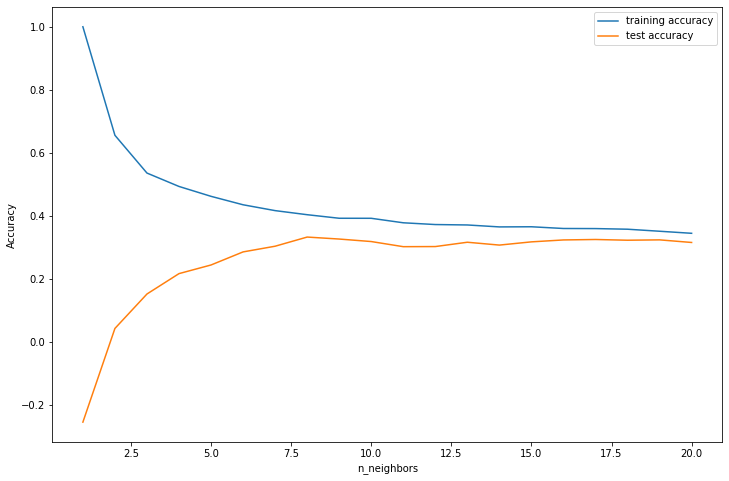

The optimal number of neighbors is: 8


In [45]:
# Determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data = X_train,
                                  y_data = y_train)

- We can observe above that we get maximum testing accuracy for n_neighbor = 8. So lets create a KNeighborsClassifier with number of neighbors as 8.

In [46]:
# Setup a knn classifier with optimum k neighbors
knn = KNeighborsClassifier(n_neighbors = opt_neighbors)

# Fit the model
knn_fit = knn.fit(X_train, y_train)

# Predict the model
knn_pred = knn_fit.predict(X_test)

# Get accuracy
knn.score(X_test, y_test).round(3)

# ROC curve and Area-Under-Curve (AUC) for KNN Classifier Model
roc_auc_knn = roc_auc_score(y_true = y_test,
                            y_score = knn_pred)


# Print the result
print('Accuracy score KNN (training):', knn_fit.score(X_train, y_train).round(3))
print('Accuracy score KNN (testing):', knn_fit.score(X_test, y_test).round(3))
print("Area under ROC curve KNN = {:0.2f}".format(roc_auc_knn))

Accuracy score KNN (training): 0.707
Accuracy score KNN (testing): 0.604
Area under ROC curve KNN = 0.51


In [47]:
# Setup a StandardScaler model
scaler = StandardScaler()

# Fit the model
scaler.fit(chef_full)

# Transform the model
X_scaled = scaler.transform(chef_full)

# Save in dataframe
X_scaled_df = pd.DataFrame(X_scaled)

# Train, test, split the scaled model
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled_df,
                                                                                chef_target,
                                                                                random_state = 222,
                                                                                test_size = 0.25,
                                                                                stratify = chef_target)


# Setup a knn classifier with optimum k neighbors
knn_optimal = KNeighborsClassifier(n_neighbors = opt_neighbors)

# Fit the model
knn_fit_scaled = knn_optimal.fit(X_train_scaled, y_train_scaled)

# Predict the model
knn_pred_scaled = knn_fit.predict(X_test_scaled)

# ROC curve and Area-Under-Curve (AUC) for KNN Classifier Model
roc_auc_knn_scaled = roc_auc_score(y_true = y_test_scaled,
                                   y_score = knn_pred_scaled)


# Print the result
print('Scaled Accuracy score KNN (training):', knn_fit_scaled.score(X_train_scaled, y_train_scaled).round(3))
print('Scaled Accuracy score KNN (testing):', knn_fit_scaled.score(X_test_scaled, y_test_scaled).round(3))
print("Scaled Area under ROC curve KNN = {:0.2f}".format(roc_auc_knn_scaled))

Scaled Accuracy score KNN (training): 0.806
Scaled Accuracy score KNN (testing): 0.717
Scaled Area under ROC curve KNN = 0.50


In [48]:
# In case of classifier like KNN the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}

# Set KNeighborsClassifier
knn_tuned = KNeighborsClassifier()

# GridSearchCV object
knn_tuned_cv = GridSearchCV(knn, 
                            param_grid, 
                            cv = 5)


# Fit to the scaled dataset
knn_tuned_cv.fit(X_train_scaled, y_train_scaled)

# INSTANTIATING a KNN tuned model with tuned values
knn_tuned_est = knn_tuned_cv.best_estimator_


# PREDICTING based on the testing set
knn_tuned_pred = knn_tuned_est.predict(X_test_scaled)


print("Tuned Parameters KNN :", knn_tuned_cv.best_params_)
print("Tuned Accuracy score KNN (training):", knn_tuned_est.score(X_train_scaled, y_train_scaled).round(3))
print("Tuned Accuracy score KNN (testing):", knn_tuned_est.score(X_test_scaled, y_test_scaled).round(3))
print("Tuned Training AUC KNN:", knn_tuned_cv.best_score_.round(3))


Tuned Parameters KNN : {'n_neighbors': 42}
Tuned Accuracy score KNN (training): 0.757
Tuned Accuracy score KNN (testing): 0.754
Tuned Training AUC KNN: 0.759


In [49]:
# Get confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_scaled, 
                       knn_tuned_pred))

# Get classification report
print(classification_report(y_test_scaled, 
                            knn_tuned_pred))

Confusion Matrix:
[[ 75  81]
 [ 39 292]]
              precision    recall  f1-score   support

           0       0.66      0.48      0.56       156
           1       0.78      0.88      0.83       331

    accuracy                           0.75       487
   macro avg       0.72      0.68      0.69       487
weighted avg       0.74      0.75      0.74       487



In [50]:
# Print the summary score results of all Gradient Boosting Classifier Model

# Baseline model KNN Classifier
print(f"""Baseline model KNN Classifier (full features):
--------------------------------------------""")
print('Accuracy score KNN (training):', knn_fit.score(X_train, y_train).round(3))
print('Accuracy score KNN (testing):', knn_fit.score(X_test, y_test).round(3))
print("Area under ROC curve KNN = {:0.2f}".format(roc_auc_knn))
print()

# Scaled model KNN Classifier
print(f"""Scaled model KNN Classifier (full features):
-------------------------------------------""")
print('Scaled Accuracy score KNN (training):', knn_fit_scaled.score(X_train_scaled, y_train_scaled).round(3))
print('Scaled Accuracy score KNN (testing):', knn_fit_scaled.score(X_test_scaled, y_test_scaled).round(3))
print("Scaled Area under ROC curve KNN = {:0.2f}".format(roc_auc_knn_scaled))
print()


# Tuned KNN Classifier result
print(f"""Tuned Parameter Gradient Boosting Classifier (full features):
------------------------------------------------------------""")
print("Tuned Parameters KNN :", knn_tuned_cv.best_params_)
print("Tuned Accuracy score KNN (training):", knn_tuned_est.score(X_train_scaled, y_train_scaled).round(3))
print("Tuned Accuracy score KNN (testing):", knn_tuned_est.score(X_test_scaled, y_test_scaled).round(3))
print("Tuned Training AUC KNN:", knn_tuned_cv.best_score_.round(3))
print()


Baseline model KNN Classifier (full features):
--------------------------------------------
Accuracy score KNN (training): 0.707
Accuracy score KNN (testing): 0.604
Area under ROC curve KNN = 0.51

Scaled model KNN Classifier (full features):
-------------------------------------------
Scaled Accuracy score KNN (training): 0.806
Scaled Accuracy score KNN (testing): 0.717
Scaled Area under ROC curve KNN = 0.50

Tuned Parameter Gradient Boosting Classifier (full features):
------------------------------------------------------------
Tuned Parameters KNN : {'n_neighbors': 42}
Tuned Accuracy score KNN (training): 0.757
Tuned Accuracy score KNN (testing): 0.754
Tuned Training AUC KNN: 0.759



**Summary KNN Classifier Model**
- For the **Tuned KNN Classifier model** with number of **neighbors as 42** achieves the best training and testing score/accuracy of **0.757 and 0.754**.
- Tuned KNN Classifier model l on training subset results in **average precision, recall, and f1-scores** on test subset were **0.74, 0.75, and 0.74** respectively.
- The **area under ROC (AUC) was 0.759**